<h1> MBA Analysis V2</h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>

<h7>3/3/22</h7>

In [460]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [461]:
%%toggle_code
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline




print('Executed')

<h3> Initial BigQuery SQL Speed Queries </h3>
<p>IPv4 with multiple concurrent TCP connections</p>

<h5>Download Queries and Dataframes</h5>

In [462]:
# DOWNLOAD***

peak_download_sql = """
SELECT
    mt_Download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(4)] as low_4_percent_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    (MAX(httpmt_bytes_sec/125000)- MIN(httpmt_bytes_sec/125000)) as Mbps_range,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
(SELECT
    mt.download as mt_download,
    mt.isp as mt_isp,
    mt.technology as mt_technology,
    httpmt.bytes_sec as httpmt_bytes_sec,
    httpmt.unit_id as httpmt_unit_id,
    PERCENTILE_CONT(httpmt.bytes_sec,.01) over (PARTITION BY httpmt.bytes_sec) as bottom_1_pct,
    PERCENTILE_CONT(httpmt.bytes_sec,.99) over (PARTITION BY httpmt.bytes_sec) as top_1_pct
    FROM
      `broadband-data.mba_data.curr_httpgetmt` as httpmt
    INNER JOIN
      `broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.Unit_ID
    WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
)   
Where httpmt_bytes_sec between bottom_1_pct and top_1_pct
GROUP BY download_service_tier, ISP, tech
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY download_service_tier, ISP, tech

"""

fullDay_download_sql = """
SELECT
    mt_Download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    (MAX(httpmt_bytes_sec/125000)- MIN(httpmt_bytes_sec/125000)) as Mbps_range,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
(SELECT
    mt.download as mt_download,
    mt.isp as mt_isp,
    mt.technology as mt_technology,
    httpmt.bytes_sec as httpmt_bytes_sec,
    httpmt.unit_id as httpmt_unit_id,
    PERCENTILE_CONT(httpmt.bytes_sec,.01) over (PARTITION BY httpmt.bytes_sec) as bottom_1_pct,
    PERCENTILE_CONT(httpmt.bytes_sec,.99) over (PARTITION BY httpmt.bytes_sec) as top_1_pct
    FROM
      `broadband-data.mba_data.curr_httpgetmt` as httpmt
    INNER JOIN
      `broadband-data.mba_data.unit-profile-sept2020` as mt ON httpmt.unit_id=mt.Unit_ID
)   
Where httpmt_bytes_sec between bottom_1_pct and top_1_pct
GROUP BY download_service_tier, ISP, tech
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY download_service_tier, ISP, tech

"""







# Creating main dataframes
peak_download = client.query(peak_download_sql).to_dataframe()
fullDay_download = client.query(fullDay_download_sql).to_dataframe()
print("Executed")

Executed


<h5>Upload Queries and Dataframes</h5>

In [463]:
# ***UPLOAD***


peak_upload_sql = """
SELECT
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httppmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httppmt_bytes_sec/125000) as max_Mbps,
    MIN(httppmt_bytes_sec/125000) as min_Mbps,
    (MAX(httppmt_bytes_sec/125000)- MIN(httppmt_bytes_sec/125000)) as Mbps_range,
    STDDEV_SAMP(httppmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httppmt_unit_id) as total_boxes
FROM
(select
    mt.upload as mt_upload,
    mt.isp as mt_isp,
    mt.technology as mt_technology,
    httppmt.bytes_sec as httppmt_bytes_sec,
    httppmt.unit_id as httppmt_unit_id,
    PERCENTILE_CONT(httppmt.bytes_sec,.01) over (PARTITION BY httppmt.bytes_sec) as bottom_1_pct,
    PERCENTILE_CONT(httppmt.bytes_sec,.99) over (PARTITION BY httppmt.bytes_sec) as top_1_pct
    FROM
      `broadband-data.mba_data.curr_httppostmt` as httppmt
    INNER JOIN
      `broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httppmt.unit_id=mt.Unit_ID
    WHERE (EXTRACT(HOUR FROM httppmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httppmt.dtime) <=23)
)   
Where httppmt_bytes_sec between bottom_1_pct and top_1_pct
GROUP BY upload_service_tier, ISP, tech
HAVING COUNT(DISTINCT httppmt_unit_id) > 9
ORDER BY upload_service_tier, ISP, tech
"""

fullDay_upload_sql = """
SELECT
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httppmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httppmt_bytes_sec/125000) as max_Mbps,
    MIN(httppmt_bytes_sec/125000) as min_Mbps,
    (MAX(httppmt_bytes_sec/125000)- MIN(httppmt_bytes_sec/125000)) as Mbps_range,
    STDDEV_SAMP(httppmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httppmt_unit_id) as total_boxes
FROM
(select
    mt.upload as mt_upload,
    mt.isp as mt_isp,
    mt.technology as mt_technology,
    httppmt.bytes_sec as httppmt_bytes_sec,
    httppmt.unit_id as httppmt_unit_id,
    PERCENTILE_CONT(httppmt.bytes_sec,.01) over (PARTITION BY httppmt.bytes_sec) as bottom_1_pct,
    PERCENTILE_CONT(httppmt.bytes_sec,.99) over (PARTITION BY httppmt.bytes_sec) as top_1_pct
    FROM
      `broadband-data.mba_data.curr_httppostmt` as httppmt
    INNER JOIN
      `broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httppmt.unit_id=mt.Unit_ID
)   
Where httppmt_bytes_sec between bottom_1_pct and top_1_pct
GROUP BY upload_service_tier, ISP, tech
HAVING COUNT(DISTINCT httppmt_unit_id) > 9
ORDER BY upload_service_tier, ISP, tech

"""



peak_upload = client.query(peak_upload_sql).to_dataframe()
fullDay_upload = client.query(fullDay_upload_sql).to_dataframe()
print("Executed")

Executed


In [464]:
peak_download 

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,low_4_percent_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
0,1.5,CenturyLink,DSL,1.210811,1.235928,0.671032,1.493808,1.064768,0.611152,1.934584,0.022072,1.912512,0.257870,65
1,3.0,CenturyLink,DSL,2.850792,2.832320,1.484872,4.766320,2.205512,1.429000,5.404400,0.016840,5.387560,0.897564,50
2,3.0,Comcast,Cable,3.511462,3.556472,3.279112,3.577728,3.540504,3.268904,3.607728,0.262824,3.344904,0.230169,10
3,3.0,Frontier,DSL,2.425750,2.632312,1.198840,3.585376,1.706096,1.172032,3.998760,0.276048,3.722712,0.724883,24
4,3.0,Verizon DSL,DSL,2.022737,2.307192,0.570384,2.804664,1.206728,0.531680,2.846840,0.115192,2.731648,0.724003,23
5,3.0,Windstream,DSL,2.598924,2.665840,0.547472,3.546224,2.091560,0.533992,4.398760,0.020112,4.378648,0.863872,15
6,4.0,Windstream,DSL,4.015566,4.367472,2.188920,4.414664,3.827016,2.066928,4.609920,0.305016,4.304904,0.728208,18
7,5.0,Cincinnati Bell,DSL,3.735885,4.216632,1.242880,4.329480,3.228968,1.103880,41.034560,0.249400,40.785160,1.448880,49
8,6.0,Frontier,DSL,5.444390,5.683616,1.770888,7.892512,4.402104,1.521736,9.551024,0.443104,9.107920,1.713407,36
9,6.0,Windstream,DSL,5.987729,5.984448,4.743992,6.866808,5.793120,4.565424,6.946528,0.211760,6.734768,0.729300,10


In [465]:
fullDay_download

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
0,1.5,CenturyLink,DSL,1.245270,1.249120,0.772224,1.523976,1.113936,1.964504,0.002232,1.962272,0.245167,65
1,3.0,CenturyLink,DSL,2.995939,2.870304,1.837240,4.902648,2.375352,9.895568,0.005592,9.889976,0.980693,50
2,3.0,Comcast,Cable,3.504590,3.557408,3.187368,3.579376,3.536304,3.683936,0.262824,3.421112,0.201568,10
3,3.0,Frontier,DSL,2.541429,2.775128,1.217840,3.619992,1.769784,4.002112,0.274936,3.727176,0.747847,24
4,3.0,Verizon DSL,DSL,2.195570,2.411232,0.864504,2.809232,1.442416,2.869192,0.005584,2.863608,0.667580,23
5,3.0,Windstream,DSL,2.721502,2.789664,0.566216,4.076968,2.308312,4.675856,0.020112,4.655744,0.816491,15
6,4.0,Windstream,DSL,4.093838,4.373088,2.500536,4.421616,3.961888,4.756280,0.305016,4.451264,0.651890,18
7,5.0,Cincinnati Bell,DSL,3.710901,4.236448,1.277048,4.711592,2.961408,41.747272,0.110608,41.636664,1.217759,49
8,6.0,Frontier,DSL,5.944643,5.823432,3.547400,8.658544,5.077416,9.565984,0.006696,9.559288,1.439046,36
9,6.0,Windstream,DSL,5.975018,5.963712,4.942840,6.856776,5.781888,6.946528,0.211760,6.734768,0.690536,10


In [466]:
peak_upload

,upload_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
0,0.256,CenturyLink,DSL,0.192903,0.203536,0.099544,0.244552,0.150984,0.471552,0.027848,0.443704,0.058068,20
1,0.384,Frontier,DSL,0.507050,0.554656,0.149840,0.697880,0.345584,0.737888,0.135312,0.602576,0.183899,13
2,0.512,CenturyLink,DSL,0.268957,0.216960,0.115192,0.530584,0.156576,0.778400,0.048608,0.729792,0.145785,51
3,0.640,CenturyLink,DSL,0.620457,0.632440,0.463008,0.763768,0.529000,0.839800,0.139792,0.700008,0.097842,22
4,0.750,CenturyLink,DSL,0.647166,0.675512,0.204672,0.850264,0.589400,1.014456,0.037072,0.977384,0.160779,34
5,0.768,CenturyLink,DSL,0.695408,0.696640,0.503280,0.877360,0.613936,1.058768,0.157696,0.901072,0.107424,55
6,0.768,Cincinnati Bell,DSL,0.556630,0.565896,0.403720,0.656512,0.515488,2.780680,0.079400,2.701280,0.110251,49
7,0.768,Frontier,DSL,0.543533,0.618712,0.197944,0.710088,0.369184,0.752800,0.174464,0.578336,0.173656,13
8,0.768,Verizon DSL,DSL,0.542049,0.583776,0.322096,0.721680,0.388224,0.759392,0.184320,0.575072,0.131573,29
9,0.768,Windstream,DSL,0.630953,0.620704,0.361232,0.860480,0.559184,1.044064,0.035792,1.008272,0.144965,65


In [467]:
fullDay_upload

,upload_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
0,0.256,CenturyLink,DSL,0.190928,0.203528,0.101776,0.248280,0.147624,0.493216,0.018472,0.474744,0.055637,20
1,0.384,Frontier,DSL,0.532650,0.571720,0.200184,0.698992,0.354528,0.737888,0.070448,0.667440,0.167175,13
2,0.512,CenturyLink,DSL,0.329353,0.297496,0.119656,0.664584,0.177192,0.778400,0.031280,0.747120,0.164379,51
3,0.640,CenturyLink,DSL,0.635622,0.641952,0.473080,0.785912,0.561432,0.869752,0.123016,0.746736,0.095204,22
4,0.750,CenturyLink,DSL,0.669256,0.687808,0.228152,0.904712,0.598344,1.014456,0.003352,1.011104,0.161193,35
5,0.768,CenturyLink,DSL,0.681091,0.688928,0.496560,0.855568,0.600296,1.140792,0.045872,1.094920,0.105969,56
6,0.768,Cincinnati Bell,DSL,0.556223,0.567016,0.395904,0.660288,0.517808,2.822952,0.071576,2.751376,0.102139,49
7,0.768,Frontier,DSL,0.504064,0.547920,0.194584,0.708936,0.276240,0.773712,0.128616,0.645096,0.180918,13
8,0.768,Verizon DSL,DSL,0.556334,0.596104,0.335400,0.721368,0.435448,0.813072,0.143152,0.669920,0.131159,29
9,0.768,Windstream,DSL,0.652364,0.633008,0.395896,0.867528,0.573720,1.125816,0.035792,1.090024,0.141902,66


In [468]:
# lower_tier_peak = peak_download.where(peak_download.download_service_tier <= 25 )
# # tier_avgs = peak_download.groupby(['download_service_tier']).mean()
# # peak_download.index.name = None
# baseBoxplots = lower_tier_peak.boxplot(column = ['median_Mbps', 'avg_Mbps'], 
#                                               by=['download_service_tier'], 
#                                               figsize = (18,8), grid = True)

                                              
# altBoxplots = lower_tier_peak.boxplot(column = ['low_20_pct_Mbps', 'low_5_pct_Mbps'], 
#                                               by=['download_service_tier'], 
#                                               figsize = (18,8), grid = True)                                            





In [469]:
# higher_tier_peak = peak_download.where(peak_download.download_service_tier > 25)
# peak_download.index.name = None
# higher_tier_boxplots = higher_tier_peak.boxplot(column = ['median_Mbps', 'avg_Mbps'], 
#                                               by=['download_service_tier'], 
#                                               figsize = (18,8), grid = True)

                                              
# altmetrics_boxplots = higher_tier_peak.boxplot(column = ['low_20_pct_Mbps', 'low_5_pct_Mbps'], 
#                                               by=['download_service_tier'], 
#                                               figsize = (18,8), grid = True)           

<h2>Charts w/ average summary stats grouped by download tier and technology</h2>

<h5> Peak vs full-day download metrics for Cable

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,low_4_percent_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
download_service_tier,,,,,,,,,,,
3.0,3.511462,3.556472,3.279112,3.577728,3.540504,3.268904,3.607728,0.262824,3.344904,0.230169,10.0
20.0,22.475906,23.200584,19.106240,23.393872,21.879872,18.456072,23.426824,13.530976,9.895848,1.485526,18.0
25.0,28.419018,29.699656,23.594880,29.793232,28.113872,22.795736,30.241992,0.197568,30.044424,3.709781,57.0
30.0,33.406116,33.992152,28.752320,36.711248,32.672616,27.964504,36.838632,8.925848,27.912784,2.679959,20.0
50.0,57.307973,59.458240,44.814584,59.744368,57.649592,42.935088,60.179224,5.741080,54.438144,5.338524,58.0
60.0,71.867807,74.961280,53.415572,75.230152,71.910984,48.867748,89.094036,2.594800,86.499236,9.629904,32.5
75.0,86.883362,88.877400,78.446848,89.412880,85.196984,77.271472,89.875416,26.249472,63.625944,4.915926,42.0
100.0,117.357441,120.026770,104.537696,121.448156,116.210858,101.958864,128.513112,7.946312,120.566800,10.036083,48.5
150.0,168.244795,175.367824,141.422848,179.172520,159.582456,136.403968,192.208792,0.048608,192.160184,18.396937,47.0


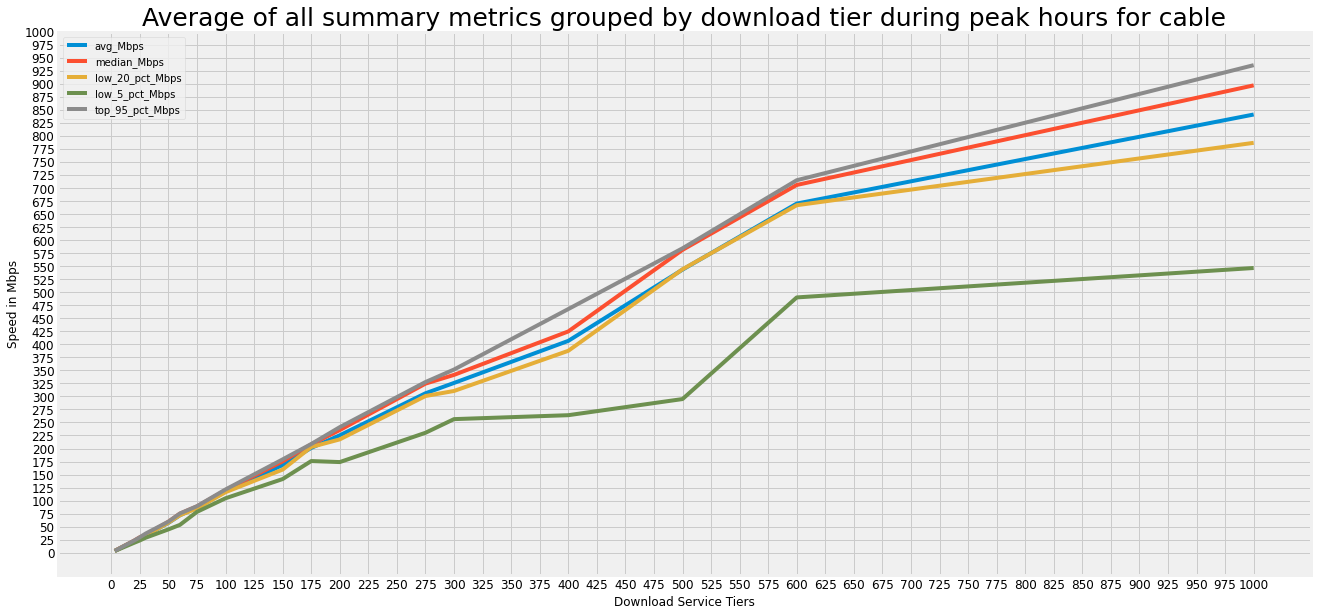

In [470]:
chartData = peak_download.where(peak_download.tech == 'Cable').groupby(['download_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (20,10), grid = True)

x = np.arange(0,1025,25)
y = np.arange(0,1025,25)

ax.set_xticks(x)
ax.set_yticks(y)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by download tier during peak hours for cable', fontsize=25)

chartData


,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
download_service_tier,,,,,,,,,,
3.0,3.504590,3.557408,3.187368,3.579376,3.536304,3.683936,0.262824,3.421112,0.201568,10.000000
20.0,22.797165,23.328320,20.191288,23.406864,22.681760,23.566928,10.126992,13.439936,1.329264,18.000000
25.0,28.856753,29.721936,25.040440,29.798944,29.013632,30.241992,0.197568,30.044424,3.027232,57.000000
30.0,33.880135,34.242344,29.319760,36.685192,33.621696,36.946680,2.164048,34.782632,2.318309,20.000000
50.0,57.418660,59.490008,43.017848,59.780232,58.372912,60.371520,0.340776,60.030744,5.403552,58.000000
60.0,72.542167,75.031824,60.792000,82.612956,73.927960,90.384808,0.916588,89.468220,10.314393,32.500000
75.0,87.776968,89.163536,82.080744,89.418240,87.840880,91.241448,2.980912,88.260536,5.015997,42.000000
100.0,118.353739,120.345528,106.492234,121.513926,118.290320,129.429358,1.901746,127.527612,8.391771,49.000000
150.0,168.225947,175.964648,143.481376,179.185904,156.348832,193.030280,0.048608,192.981672,18.185553,48.000000


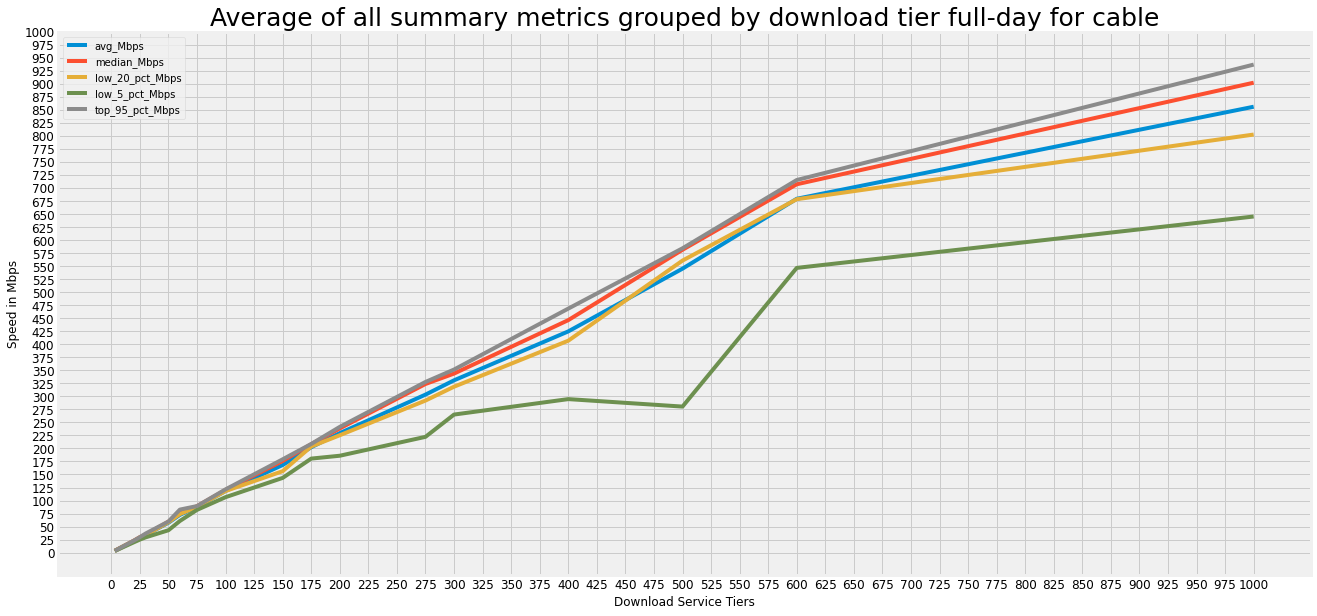

In [471]:
chartData = fullDay_download.where(fullDay_download.tech == 'Cable').groupby(['download_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (20,10), grid = True)

x = np.arange(0,1025,25)
y = np.arange(0,1025,25)

ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by download tier full-day for cable', fontsize=25)

chartData


<h5> Peak vs full-day download metrics for Fiber

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,low_4_percent_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
download_service_tier,,,,,,,,,,,
50.0,55.815540,56.933688,49.900600,57.236872,55.206048,48.636012,65.501016,23.396012,42.105004,2.757140,38.5
75.0,80.841834,82.008308,74.599420,82.966984,80.107828,73.632376,88.821500,10.092572,78.728928,4.226503,46.5
100.0,98.045371,99.510636,91.638104,100.148660,97.006620,90.772876,101.950444,39.134628,62.815816,4.060608,59.5
150.0,146.912836,149.071328,139.318656,149.934440,144.469352,138.179944,152.381424,0.125136,152.256288,7.606402,25.0
200.0,249.143214,253.175676,225.557108,255.726420,247.050292,223.150400,256.813080,111.226828,145.586252,11.835106,29.0
250.0,269.268102,272.223464,262.790272,272.562752,270.963152,259.957808,353.850472,93.818320,260.032152,14.144957,42.0
500.0,447.878028,441.092088,317.764320,527.323816,407.259904,304.618512,558.254904,57.599936,500.654968,90.160851,105.0
940.0,762.927242,766.347776,571.683432,926.081928,675.475416,553.204648,932.462456,66.296056,866.166400,110.348363,93.0
1000.0,616.365070,546.675960,373.116600,883.338316,444.880756,361.791444,927.467380,163.565244,763.902136,186.305384,45.5


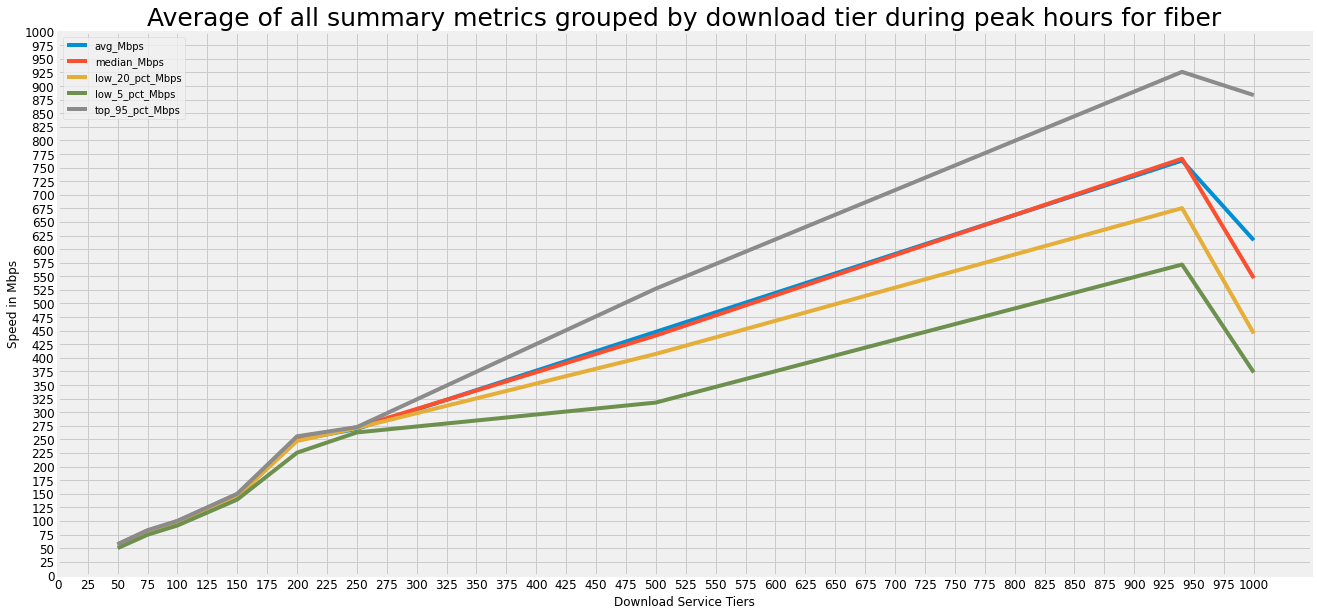

In [472]:
chartData = peak_download.where(peak_download.tech == 'Fiber').groupby(['download_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (20,10), grid = True)

x = np.arange(0,1025,25)
y = np.arange(0,1025,25)

ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by download tier during peak hours for fiber', fontsize=25)

chartData

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
download_service_tier,,,,,,,,,,
50.0,56.104621,56.951508,50.946004,57.238452,56.282644,65.576364,15.581096,49.995268,2.461790,39.0
75.0,81.336204,82.075804,76.710116,83.009972,81.110308,88.845268,6.442404,82.402864,3.480771,46.5
100.0,98.806475,99.772372,93.683264,100.478892,98.614104,102.136580,24.997652,77.138928,3.006103,60.0
150.0,147.958061,149.364760,142.405168,150.281936,147.770264,153.086344,0.061504,153.024840,6.514487,25.0
200.0,250.139715,253.897176,228.192400,255.771504,250.503892,257.968856,23.327284,234.641572,12.273768,29.0
250.0,268.702963,272.236504,259.466384,272.563000,271.319128,369.846496,86.450560,283.395936,15.935389,42.0
500.0,456.969827,442.847428,342.688412,527.441412,416.067192,558.736712,10.262200,548.474512,79.913855,105.5
940.0,770.748348,778.003800,578.968272,926.687104,693.041720,934.983608,30.384576,904.599032,105.524526,94.0
1000.0,625.793381,556.405040,377.329020,885.447080,448.718892,928.408992,27.178480,901.230512,187.904081,45.5


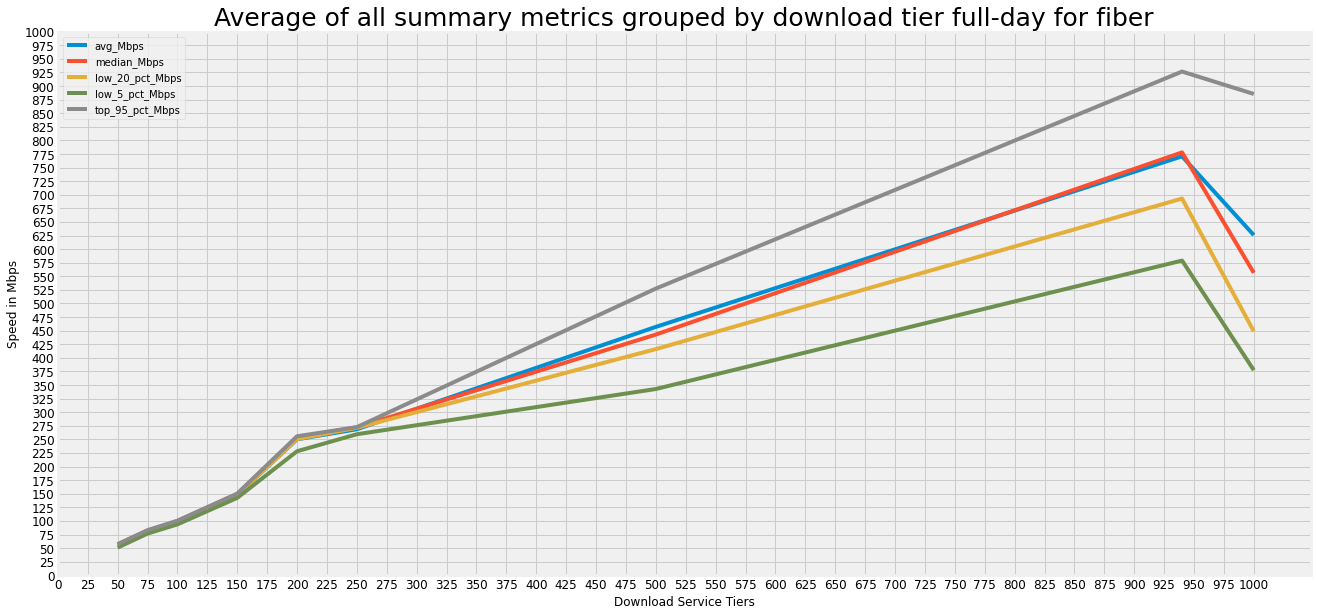

In [473]:
chartData = fullDay_download.where(fullDay_download.tech == 'Fiber').groupby(['download_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (20,10), grid = True)

x = np.arange(0,1025,25)
y = np.arange(0,1025,25)

ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by download tier full-day for fiber', fontsize=25)

chartData

<h5> Peak vs full-day download metrics for DSL

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,low_4_percent_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
download_service_tier,,,,,,,,,,,
1.5,1.210811,1.235928,0.671032,1.493808,1.064768,0.611152,1.934584,0.022072,1.912512,0.257870,65.000000
3.0,2.474551,2.609416,0.950392,3.675646,1.802474,0.916676,4.162190,0.107048,4.055142,0.802581,28.000000
4.0,4.015566,4.367472,2.188920,4.414664,3.827016,2.066928,4.609920,0.305016,4.304904,0.728208,18.000000
5.0,3.735885,4.216632,1.242880,4.329480,3.228968,1.103880,41.034560,0.249400,40.785160,1.448880,49.000000
6.0,5.716059,5.834032,3.257440,7.379660,5.097612,3.043580,8.248776,0.327432,7.921344,1.221353,23.000000
7.0,7.090968,7.221384,4.771928,8.535000,5.890320,4.653488,101.038368,1.884872,99.153496,3.908118,28.000000
8.0,7.063737,7.463440,4.764104,9.892416,5.701512,4.558488,9.930472,1.966432,7.964040,1.448562,19.000000
10.0,8.965091,9.273373,6.076701,10.711443,8.016531,5.578963,12.349453,1.337739,11.011715,1.559577,45.666667
12.0,12.383266,12.340800,8.416507,15.845421,10.917768,7.799992,17.910112,0.830243,17.079869,2.422858,60.666667


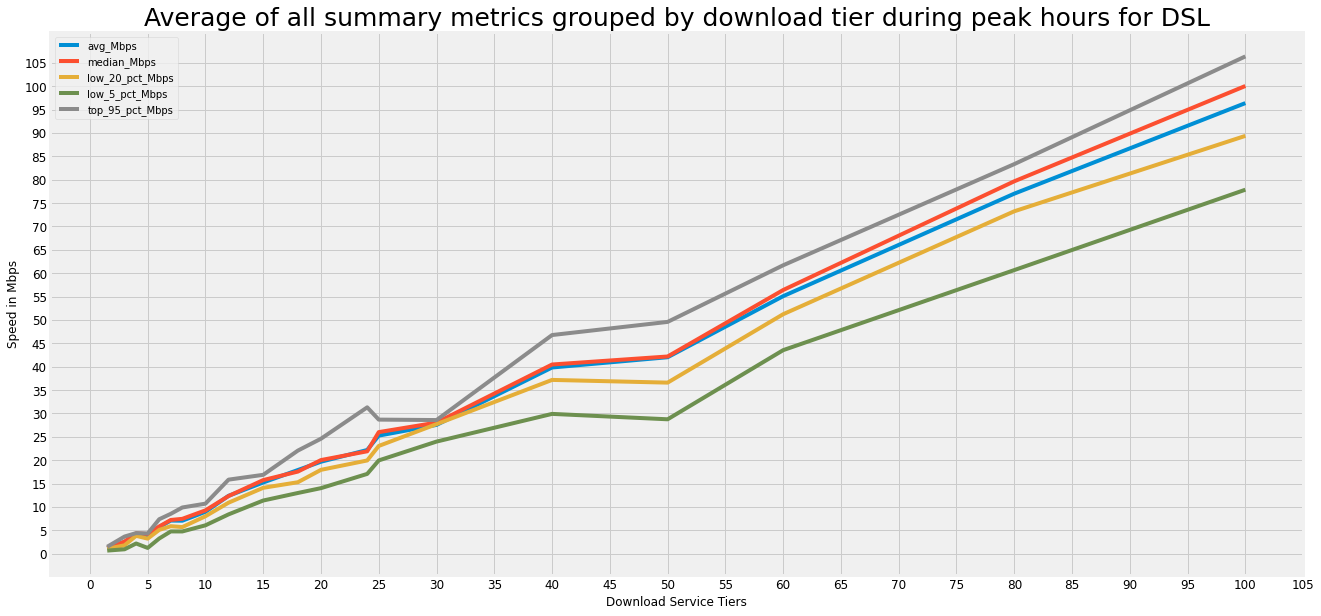

In [474]:
chartData = peak_download.where(peak_download.tech == 'DSL').groupby(['download_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (20,10), grid = True)

x = np.arange(0,110,5)
y = np.arange(0,110,5)

ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by download tier during peak hours for DSL', fontsize=25)

chartData

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
download_service_tier,,,,,,,,,,
1.5,1.245270,1.249120,0.772224,1.523976,1.113936,1.964504,0.002232,1.962272,0.245167,65.000000
3.0,2.613610,2.711582,1.121450,3.852210,1.973966,5.360682,0.076556,5.284126,0.803153,28.000000
4.0,4.093838,4.373088,2.500536,4.421616,3.961888,4.756280,0.305016,4.451264,0.651890,18.000000
5.0,3.710901,4.236448,1.277048,4.711592,2.961408,41.747272,0.110608,41.636664,1.217759,49.000000
6.0,5.959831,5.893572,4.245120,7.757660,5.429652,8.256256,0.109228,8.147028,1.064791,23.000000
7.0,5.908669,6.480244,3.790952,7.595844,4.348472,53.880400,1.742348,52.138052,1.851109,20.000000
8.0,7.195517,7.665712,4.963528,9.794136,5.973024,10.034440,0.120664,9.913776,1.373055,19.000000
10.0,9.177605,9.543227,6.743525,10.796456,8.341541,12.378859,0.969763,11.409096,1.419988,46.666667
12.0,12.459315,12.364949,8.774784,15.669973,10.946163,17.944275,0.181960,17.762315,2.352374,61.000000


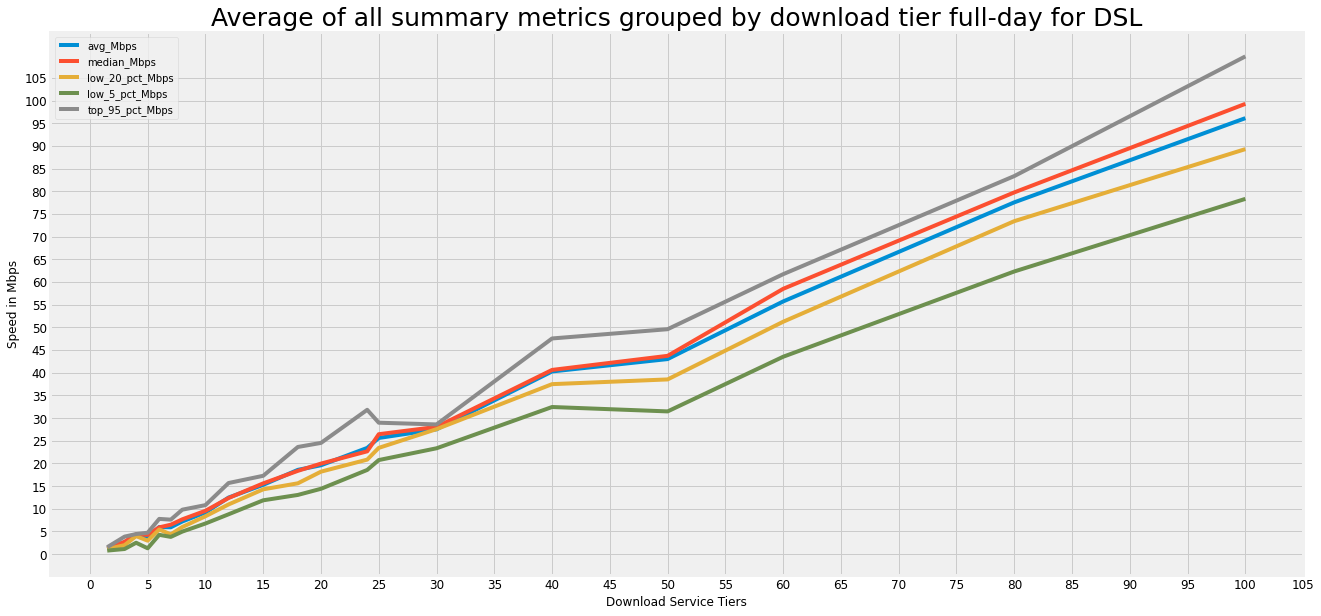

In [475]:
chartData = fullDay_download.where(fullDay_download.tech == 'DSL').groupby(['download_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (20,10), grid = True)

x = np.arange(0,110,5)
y = np.arange(0,110,5)

ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by download tier full-day for DSL', fontsize=25)

chartData

<h2>Charts w/ average summary stats grouped by upload tier and technology</h2>

<h5> Peak vs full-day upload metrics for Cable

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
upload_service_tier,,,,,,,,,,
2.0,2.299681,2.324876,2.071264,2.455992,2.226140,2.642548,1.337836,1.304712,0.134220,21.500000
3.0,3.163031,3.191536,2.987416,3.279968,3.149600,3.568224,0.713536,2.854688,0.211641,52.000000
4.0,4.473288,4.518312,4.116912,4.670400,4.416240,4.802392,2.699360,2.103032,0.210414,14.000000
5.0,5.921169,5.790389,4.977965,7.526621,5.642952,20.358139,1.216800,19.141339,1.033882,85.666667
10.0,11.116663,11.037378,9.421678,12.806738,10.807038,13.691042,0.990650,12.700392,1.230362,85.500000
15.0,17.247182,17.407552,16.229544,17.866872,17.274408,18.113776,8.254960,9.858816,0.981138,36.000000
20.0,22.745217,23.265315,18.770709,24.888219,22.194696,25.756872,1.825317,23.931555,2.484393,56.333333
30.0,29.497175,30.608908,16.433264,32.814808,29.615772,35.191092,0.618452,34.572640,5.287943,42.000000
35.0,34.353309,36.523688,21.993152,39.511051,32.247128,40.596347,1.538795,39.057552,5.945530,73.666667


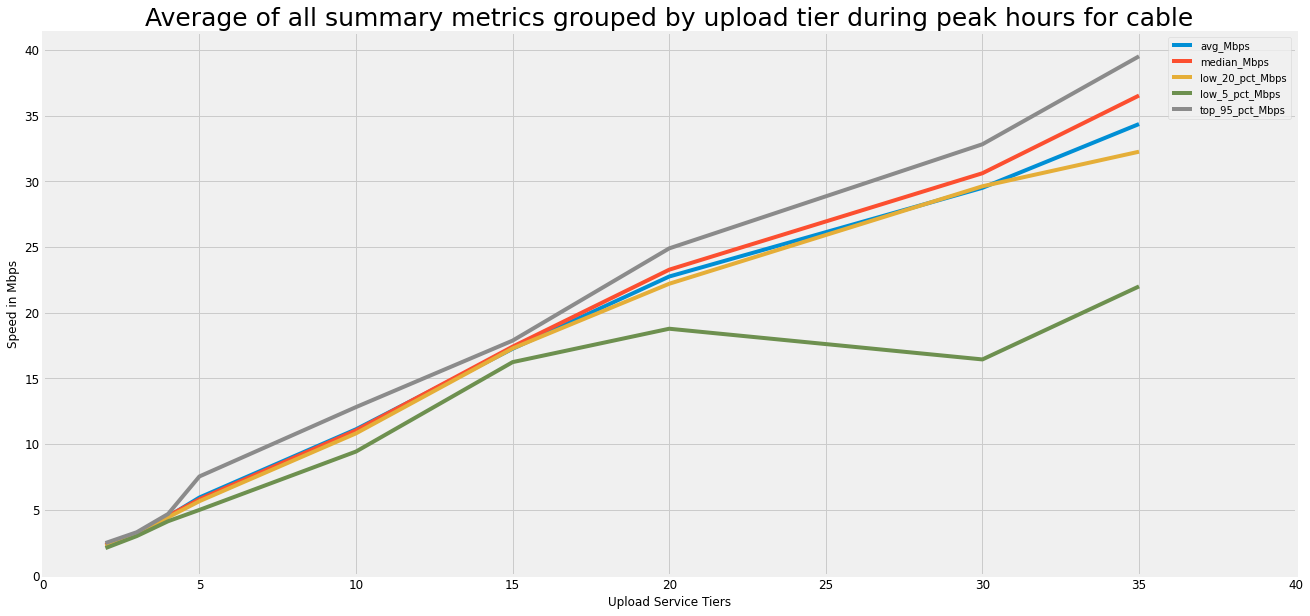

In [476]:
chartData = peak_upload.where(peak_upload.tech == 'Cable').groupby(['upload_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (20,10), grid = True)

x = np.arange(0,45,5)
y = np.arange(0,45,5)

ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by upload tier during peak hours for cable', fontsize=25)

chartData


,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
upload_service_tier,,,,,,,,,,
2.0,2.306709,2.331848,2.094456,2.451996,2.237432,2.642548,0.625672,2.016876,0.123543,21.500000
3.0,3.169538,3.196972,2.999656,3.278804,3.153036,3.689004,0.320844,3.368160,0.201383,52.000000
4.0,4.516048,4.540680,4.284600,4.672648,4.441024,4.985816,2.469416,2.516400,0.164288,14.000000
5.0,5.958213,5.797448,5.087520,7.542288,5.659003,319.575693,0.263629,319.312064,2.278568,87.000000
10.0,11.174141,11.046476,10.097862,12.846860,10.836476,13.895476,0.265682,13.629794,1.231558,85.750000
15.0,17.135553,17.394768,15.552048,17.868032,17.195808,18.192976,0.034672,18.158304,1.311346,37.000000
20.0,22.861196,23.240075,20.352331,24.851629,22.268808,25.935571,0.571864,25.363707,2.287004,57.000000
30.0,29.872871,30.538900,23.893796,33.068280,29.651964,35.434148,0.121348,35.312800,4.478685,42.000000
35.0,34.630785,36.582829,21.898213,39.518440,33.713661,40.711653,0.911488,39.800165,5.789238,74.333333


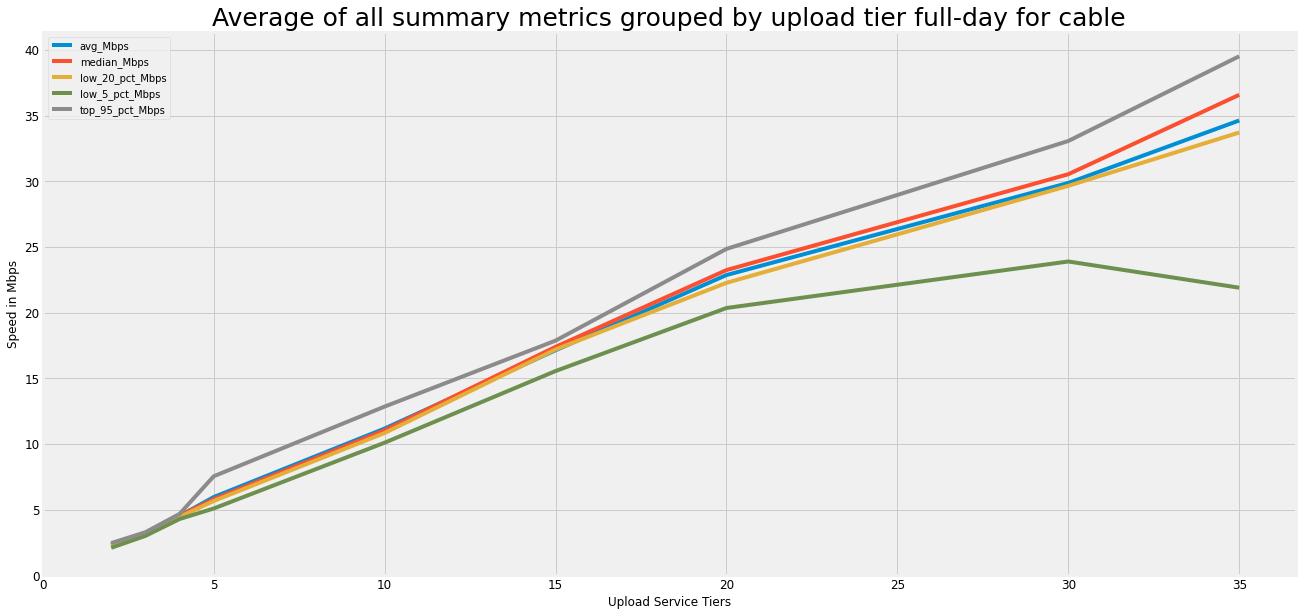

In [477]:
chartData = fullDay_upload.where(fullDay_upload.tech == 'Cable').groupby(['upload_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (20,10), grid = True)

x = np.arange(0,40,5)
y = np.arange(0,45,5)

ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by upload tier full-day for cable', fontsize=25)

chartData

<h5> Peak vs full-day upload metrics for Fiber

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
upload_service_tier,,,,,,,,,,
50.0,60.500305,61.807192,54.115424,66.561324,55.566880,70.588612,34.310324,36.278288,4.507544,38.000000
75.0,82.170666,85.840380,69.754836,90.607012,73.443004,93.856360,11.660144,82.196216,8.067000,46.500000
100.0,110.869387,113.017619,101.844099,115.844733,107.179064,124.497261,38.218875,86.278387,7.197155,53.666667
125.0,131.743156,132.010248,129.681488,135.662160,131.744608,217.946792,42.301848,175.644944,7.668349,141.000000
150.0,151.001414,150.972808,149.375568,163.936200,150.727904,164.654520,0.497000,164.157520,18.634483,25.000000
200.0,260.177129,267.837164,224.012344,288.452568,250.013068,293.859484,92.682436,201.177048,25.924817,28.500000
500.0,505.554735,507.399120,455.543472,555.885832,493.525816,563.177928,144.816160,418.361768,44.507128,69.000000
880.0,893.885556,921.215120,768.758080,938.763896,884.503528,940.378816,40.312256,900.066560,92.184092,92.000000
1000.0,859.539908,914.827228,475.028160,934.493052,840.632488,941.472604,298.332304,643.140300,134.434260,45.500000


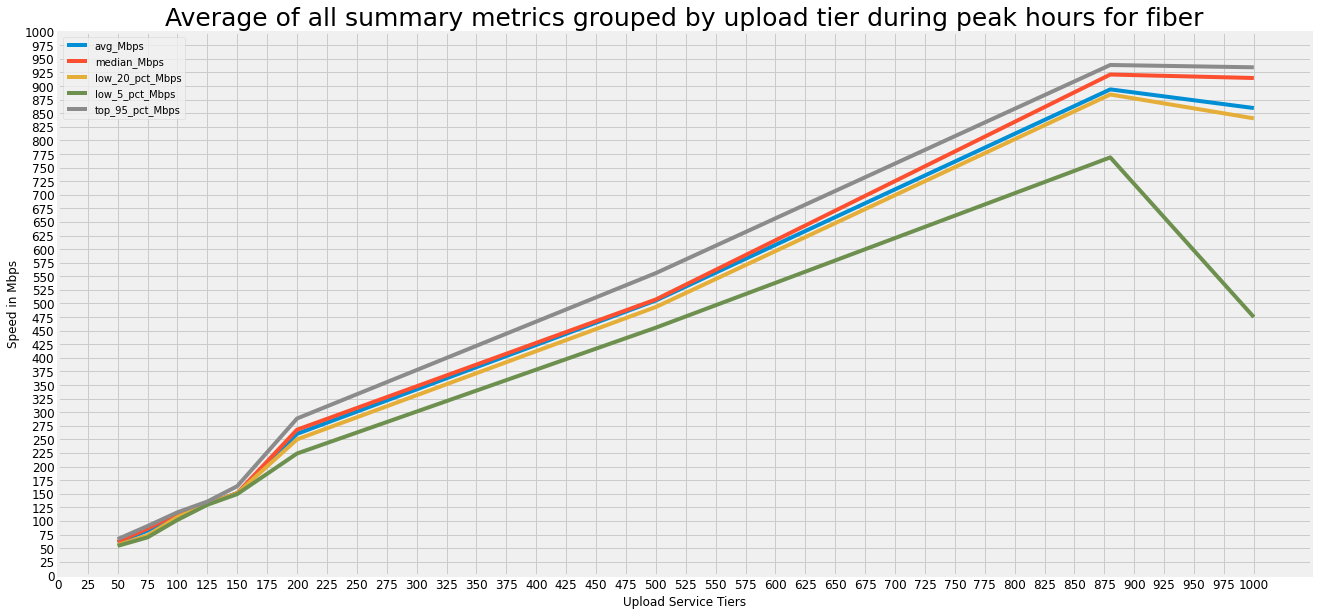

In [478]:
chartData = peak_upload.where(peak_upload.tech == 'Fiber').groupby(['upload_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (20,10), grid = True)

x = np.arange(0,1025,25)
y = np.arange(0,1025,25)

ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by upload tier during peak hours for fiber', fontsize=25)

chartData

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
upload_service_tier,,,,,,,,,,
50.0,60.538715,61.864180,54.144576,66.648204,55.527820,70.592560,31.085584,39.506976,4.428535,38.5
75.0,82.588335,85.748832,70.452740,90.697040,74.032852,93.859288,11.660144,82.199144,7.607434,46.5
100.0,110.652711,113.048840,104.101525,115.767248,106.515675,124.879736,16.948451,107.931285,6.889878,54.0
125.0,131.809241,131.971648,130.214976,135.613776,131.746600,217.946792,1.543152,216.403640,7.073977,141.0
150.0,146.476894,150.987464,143.946032,163.664880,150.708296,164.726768,0.497000,164.229768,29.782761,25.0
200.0,261.585843,268.151416,220.158000,290.628124,259.829856,294.045596,48.755104,245.290492,26.519372,29.0
500.0,503.450266,505.804440,426.021056,555.887712,496.674408,563.450880,137.499112,425.951768,44.367938,70.0
880.0,894.013193,922.469128,760.297544,938.795008,885.764160,941.464352,2.935952,938.528400,94.825991,94.0
1000.0,865.102589,924.676164,570.433108,934.653956,846.382980,941.472604,224.854700,716.617904,132.659614,45.5


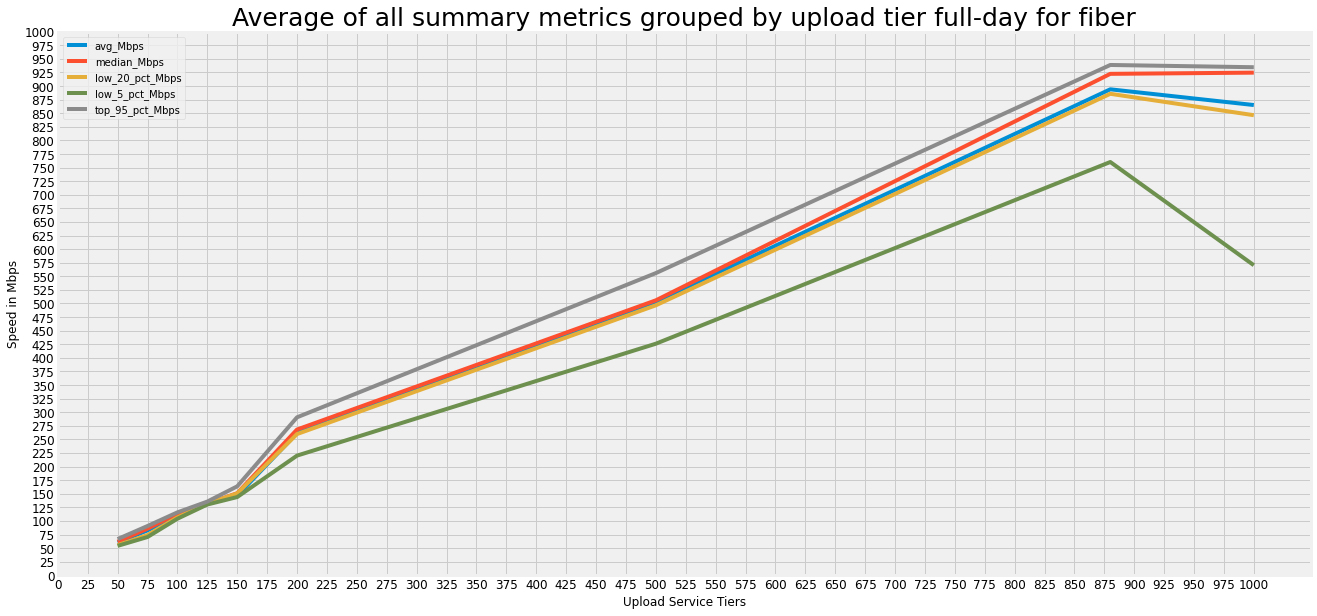

In [479]:
chartData = fullDay_upload.where(fullDay_upload.tech == 'Fiber').groupby(['upload_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (20,10), grid = True)

x = np.arange(0,1025,25)
y = np.arange(0,1025,25)

ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by upload tier full-day for fiber', fontsize=25)

chartData

<h5> Peak vs full-day upload metrics for DSL

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
upload_service_tier,,,,,,,,,,
0.256,0.192903,0.203536,0.099544,0.244552,0.150984,0.471552,0.027848,0.443704,0.058068,20.0
0.384,0.507050,0.554656,0.149840,0.697880,0.345584,0.737888,0.135312,0.602576,0.183899,13.0
0.512,0.268957,0.216960,0.115192,0.530584,0.156576,0.778400,0.048608,0.729792,0.145785,51.0
0.640,0.620457,0.632440,0.463008,0.763768,0.529000,0.839800,0.139792,0.700008,0.097842,22.0
0.750,0.647166,0.675512,0.204672,0.850264,0.589400,1.014456,0.037072,0.977384,0.160779,34.0
0.768,0.593715,0.617146,0.357654,0.765224,0.489203,1.279141,0.126334,1.152806,0.133574,42.2
0.896,0.720217,0.705512,0.507744,0.883784,0.629648,101.051776,0.178928,100.872848,1.285278,133.0
1.000,0.903751,0.864696,0.605472,1.431460,0.719786,1.667038,0.216320,1.450718,0.255145,57.5
1.500,1.377577,1.367435,0.871872,1.974275,1.093253,2.327915,0.342581,1.985333,0.350394,63.0


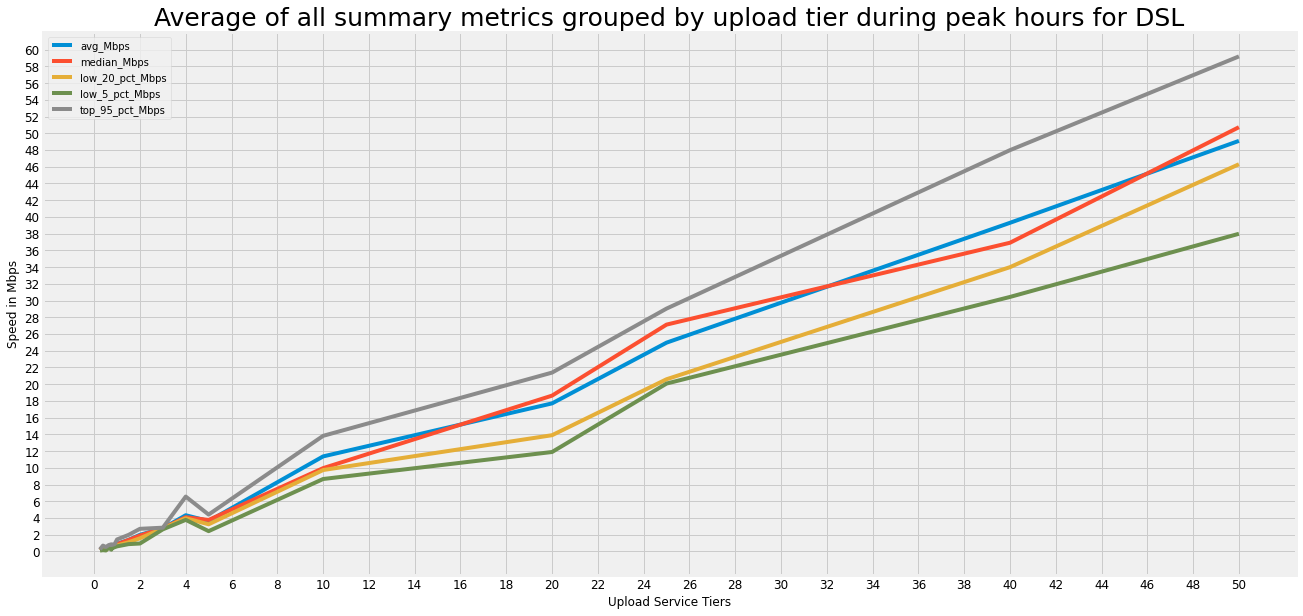

In [480]:
chartData = peak_upload.where(peak_upload.tech == 'DSL').groupby(['upload_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (20,10), grid = True)

x = np.arange(0,51, 2)
y = np.arange(0,62, 2)

ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by upload tier during peak hours for DSL', fontsize=25)

chartData

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
upload_service_tier,,,,,,,,,,
0.256,0.190928,0.203528,0.101776,0.248280,0.147624,0.493216,0.018472,0.474744,0.055637,20.0
0.384,0.532650,0.571720,0.200184,0.698992,0.354528,0.737888,0.070448,0.667440,0.167175,13.0
0.512,0.329353,0.297496,0.119656,0.664584,0.177192,0.778400,0.031280,0.747120,0.164379,51.0
0.640,0.635622,0.641952,0.473080,0.785912,0.561432,0.869752,0.123016,0.746736,0.095204,22.0
0.750,0.669256,0.687808,0.228152,0.904712,0.598344,1.014456,0.003352,1.011104,0.161193,35.0
0.768,0.590015,0.606595,0.363669,0.762738,0.480702,1.335269,0.085002,1.250267,0.132417,42.6
0.896,0.710113,0.706824,0.508488,0.883576,0.634128,101.051776,0.053680,100.998096,0.728985,134.0
1.000,0.899041,0.866082,0.641133,1.361448,0.730019,1.644744,0.179562,1.465182,0.229126,48.6
1.500,1.412395,1.442035,0.871765,2.064461,1.107123,2.336312,0.341091,1.995221,0.369189,63.0


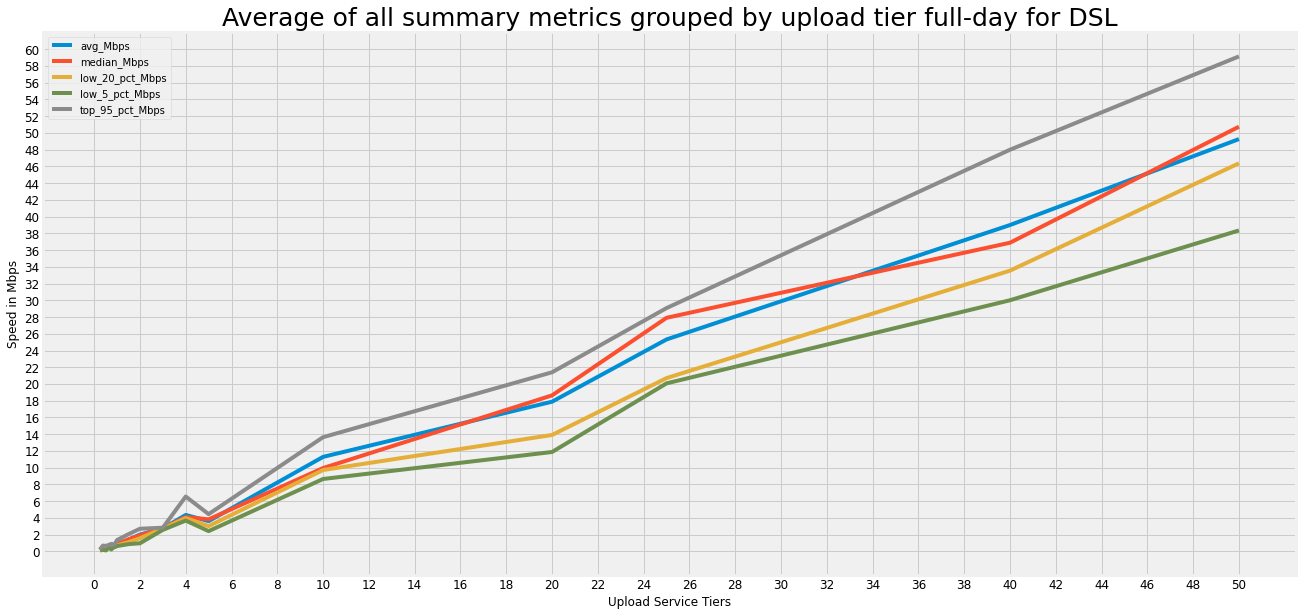

In [481]:
chartData = fullDay_upload.where(fullDay_upload.tech == 'DSL').groupby(['upload_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (20,10), grid = True)

x = np.arange(0,51, 2)
y = np.arange(0,62, 2)

ax.set_xticks(x)
ax.set_yticks(y)

ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by upload tier full-day for DSL', fontsize=25)

chartData

<h3> Barchart Tier analysis cable and fiber peak hours download

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,low_4_percent_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
download_service_tier,,,,,,,,,,,
3.0,3.511462,3.556472,3.279112,3.577728,3.540504,3.268904,3.607728,0.262824,3.344904,0.230169,10.0
20.0,22.475906,23.200584,19.106240,23.393872,21.879872,18.456072,23.426824,13.530976,9.895848,1.485526,18.0
25.0,28.419018,29.699656,23.594880,29.793232,28.113872,22.795736,30.241992,0.197568,30.044424,3.709781,57.0
30.0,33.406116,33.992152,28.752320,36.711248,32.672616,27.964504,36.838632,8.925848,27.912784,2.679959,20.0
50.0,57.307973,59.458240,44.814584,59.744368,57.649592,42.935088,60.179224,5.741080,54.438144,5.338524,58.0
60.0,71.867807,74.961280,53.415572,75.230152,71.910984,48.867748,89.094036,2.594800,86.499236,9.629904,32.5
75.0,86.883362,88.877400,78.446848,89.412880,85.196984,77.271472,89.875416,26.249472,63.625944,4.915926,42.0
100.0,117.357441,120.026770,104.537696,121.448156,116.210858,101.958864,128.513112,7.946312,120.566800,10.036083,48.5


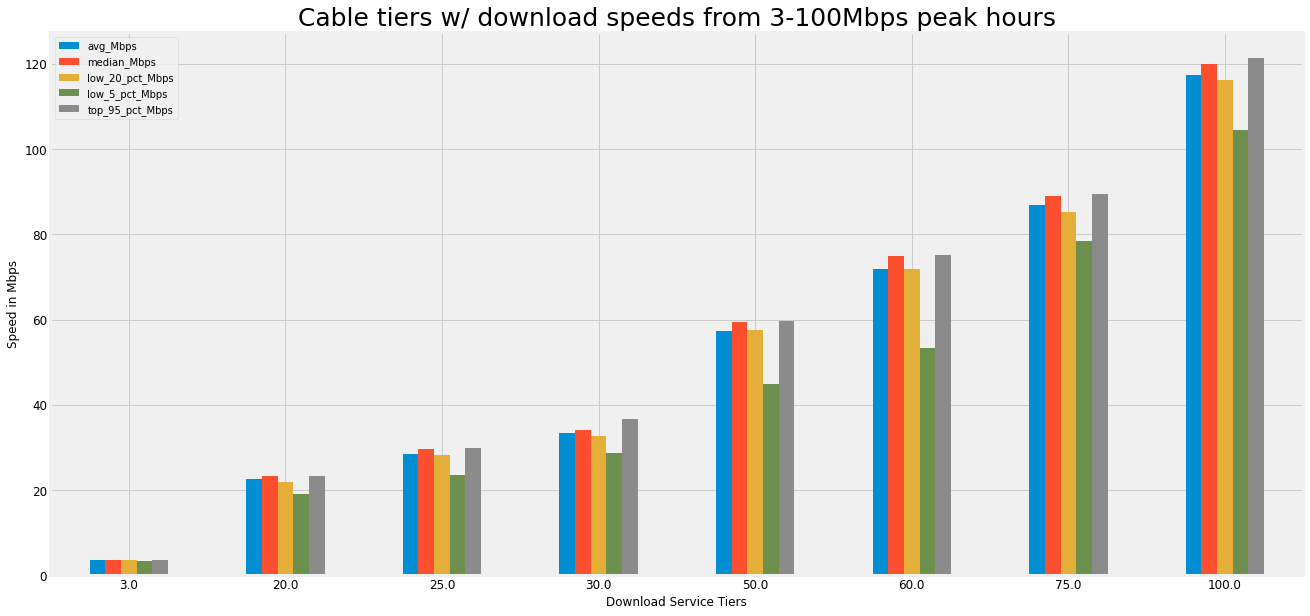

In [482]:
chartData = peak_download.where(peak_download.tech == 'Cable').groupby(['download_service_tier']).mean()

chartData = chartData[chartData.index <= 100]
ax = chartData.plot.bar(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, rot = 0, figsize = (20,10), grid = True)

# x = np.arange(0,270,5)
# y = np.arange(0,200,5)

# ax.set_xticks()
# ax.set_yticks()

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Cable tiers w/ download speeds from 3-100Mbps peak hours', fontsize=25)

chartData

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,low_4_percent_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
download_service_tier,,,,,,,,,,,
150.0,168.244795,175.367824,141.422848,179.172520,159.582456,136.403968,192.208792,0.048608,192.160184,18.396937,47.0
175.0,201.187753,207.945368,175.948088,208.656456,202.934920,166.846896,208.998904,12.501008,196.497896,24.287269,40.0
200.0,225.367903,235.445874,173.973694,241.037738,217.555451,164.818936,269.836642,7.700698,262.135944,27.032900,56.6
275.0,305.999759,324.531584,230.206600,327.569776,300.766592,213.516784,328.303608,21.405040,306.898568,44.639495,14.0
300.0,325.868565,341.329925,256.403013,351.619736,310.443381,238.327923,354.408832,8.904632,345.504200,42.002304,47.0
400.0,406.573956,424.699252,263.954524,467.640152,387.525700,252.251072,469.573144,4.535596,465.037548,67.495383,52.5
500.0,543.318856,581.233204,294.918728,584.241832,544.018352,267.086684,586.393816,8.431100,577.962716,95.152423,27.5


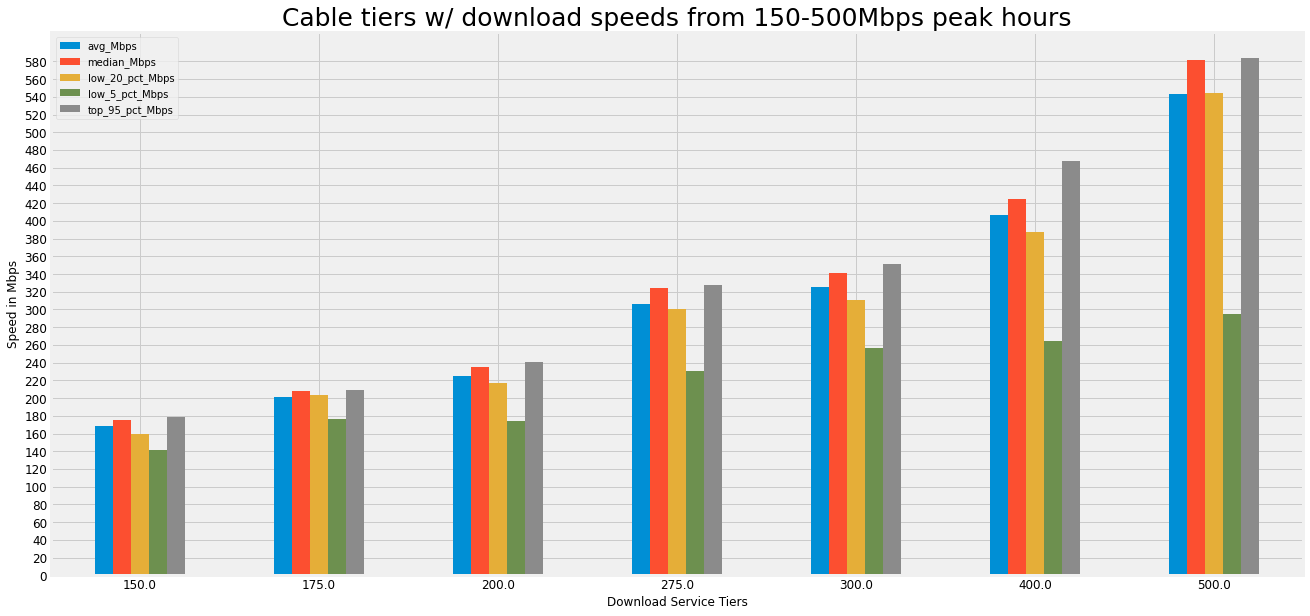

In [483]:
chartData = peak_download.where(peak_download.tech == 'Cable').groupby(['download_service_tier']).mean()

chartData = chartData[chartData.index > 100]
chartData= chartData[chartData.index <= 500]
ax = chartData.plot.bar(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, rot = 0, figsize = (20,10), grid = True)

# x = np.arange(0,270,5)
y = np.arange(0,600,20)


# ax.set_xticks()
ax.set_yticks(y)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Cable tiers w/ download speeds from 150-500Mbps peak hours', fontsize=25)

chartData

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,low_4_percent_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
download_service_tier,,,,,,,,,,,
50.0,55.815540,56.933688,49.900600,57.236872,55.206048,48.636012,65.501016,23.396012,42.105004,2.757140,38.5
75.0,80.841834,82.008308,74.599420,82.966984,80.107828,73.632376,88.821500,10.092572,78.728928,4.226503,46.5
100.0,98.045371,99.510636,91.638104,100.148660,97.006620,90.772876,101.950444,39.134628,62.815816,4.060608,59.5
150.0,146.912836,149.071328,139.318656,149.934440,144.469352,138.179944,152.381424,0.125136,152.256288,7.606402,25.0
200.0,249.143214,253.175676,225.557108,255.726420,247.050292,223.150400,256.813080,111.226828,145.586252,11.835106,29.0
250.0,269.268102,272.223464,262.790272,272.562752,270.963152,259.957808,353.850472,93.818320,260.032152,14.144957,42.0
500.0,447.878028,441.092088,317.764320,527.323816,407.259904,304.618512,558.254904,57.599936,500.654968,90.160851,105.0


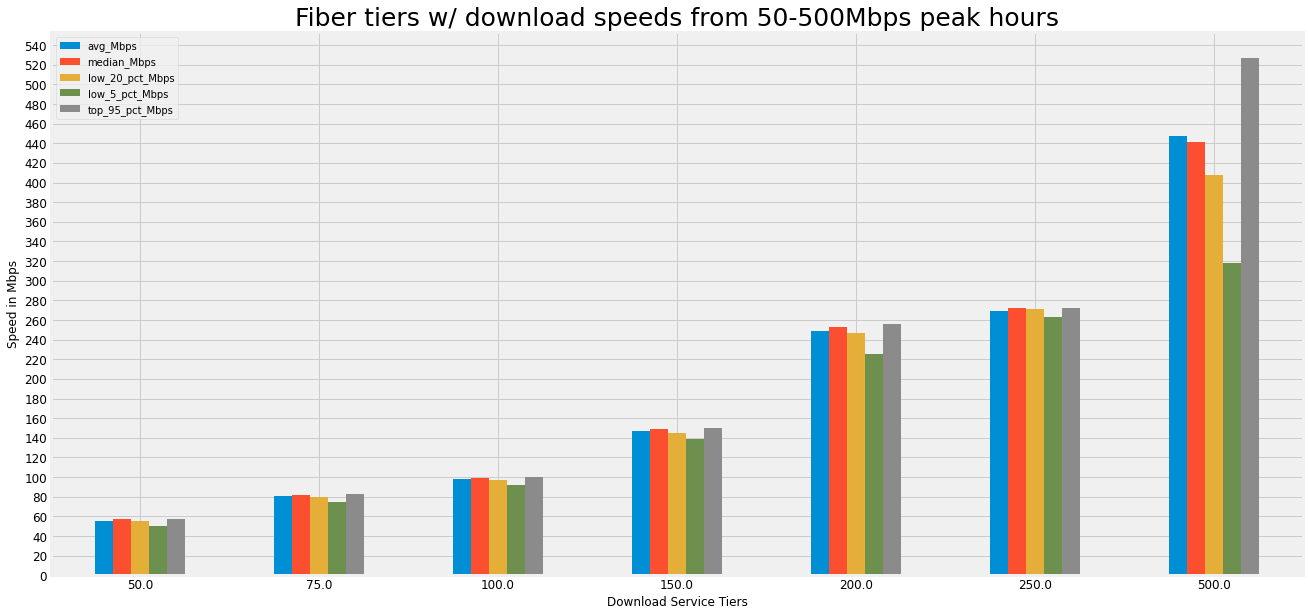

In [484]:
chartData = peak_download.where(peak_download.tech == 'Fiber').groupby(['download_service_tier']).mean()

chartData = chartData[chartData.index <= 500]
ax = chartData.plot.bar(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, rot = 0, figsize = (20,10), grid = True)

# x = np.arange(0,270,5)
y = np.arange(0,560,20)


# ax.set_xticks()
ax.set_yticks(y)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Fiber tiers w/ download speeds from 50-500Mbps peak hours', fontsize=25)

chartData

<h3> Barchart Tier analysis cable and fiber fullday download


,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
download_service_tier,,,,,,,,,,
3.0,3.504590,3.557408,3.187368,3.579376,3.536304,3.683936,0.262824,3.421112,0.201568,10.0
20.0,22.797165,23.328320,20.191288,23.406864,22.681760,23.566928,10.126992,13.439936,1.329264,18.0
25.0,28.856753,29.721936,25.040440,29.798944,29.013632,30.241992,0.197568,30.044424,3.027232,57.0
30.0,33.880135,34.242344,29.319760,36.685192,33.621696,36.946680,2.164048,34.782632,2.318309,20.0
50.0,57.418660,59.490008,43.017848,59.780232,58.372912,60.371520,0.340776,60.030744,5.403552,58.0
60.0,72.542167,75.031824,60.792000,82.612956,73.927960,90.384808,0.916588,89.468220,10.314393,32.5
75.0,87.776968,89.163536,82.080744,89.418240,87.840880,91.241448,2.980912,88.260536,5.015997,42.0
100.0,118.353739,120.345528,106.492234,121.513926,118.290320,129.429358,1.901746,127.527612,8.391771,49.0


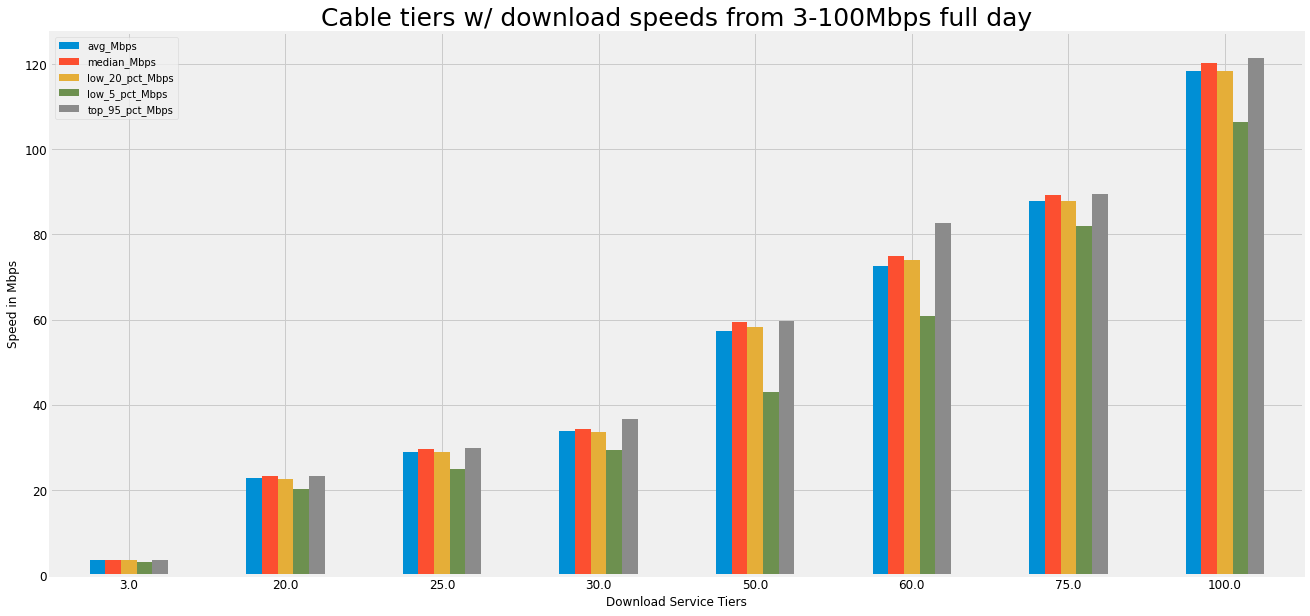

In [485]:
chartData = fullDay_download.where(fullDay_download.tech == 'Cable').groupby(['download_service_tier']).mean()

chartData = chartData[chartData.index <= 100]
ax = chartData.plot.bar(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, rot = 0, figsize = (20,10), grid = True)

# x = np.arange(0,270,5)
# y = np.arange(0,200,5)

# ax.set_xticks()
# ax.set_yticks()

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Cable tiers w/ download speeds from 3-100Mbps full day', fontsize=25)

chartData

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
download_service_tier,,,,,,,,,,
150.0,168.225947,175.964648,143.481376,179.185904,156.348832,193.030280,0.048608,192.981672,18.185553,48.000000
175.0,202.412976,208.127736,180.536072,208.660040,203.707440,209.235528,1.975416,207.260112,20.576733,41.000000
200.0,229.437178,238.459901,186.029547,241.426914,225.374984,352.445218,4.829267,347.615950,23.234023,57.000000
275.0,303.363258,323.741912,222.289952,327.641576,291.926024,328.755512,12.189256,316.566256,48.778207,14.000000
300.0,330.784196,343.735765,265.052077,351.477581,318.529597,356.185165,7.308765,348.876400,35.834922,47.666667
400.0,424.707847,446.328900,294.719508,468.454480,406.827320,476.391040,2.360284,474.030756,60.525710,53.500000
500.0,545.116506,581.380928,280.377472,584.218056,560.621576,586.460468,0.466008,585.994460,97.474797,27.500000


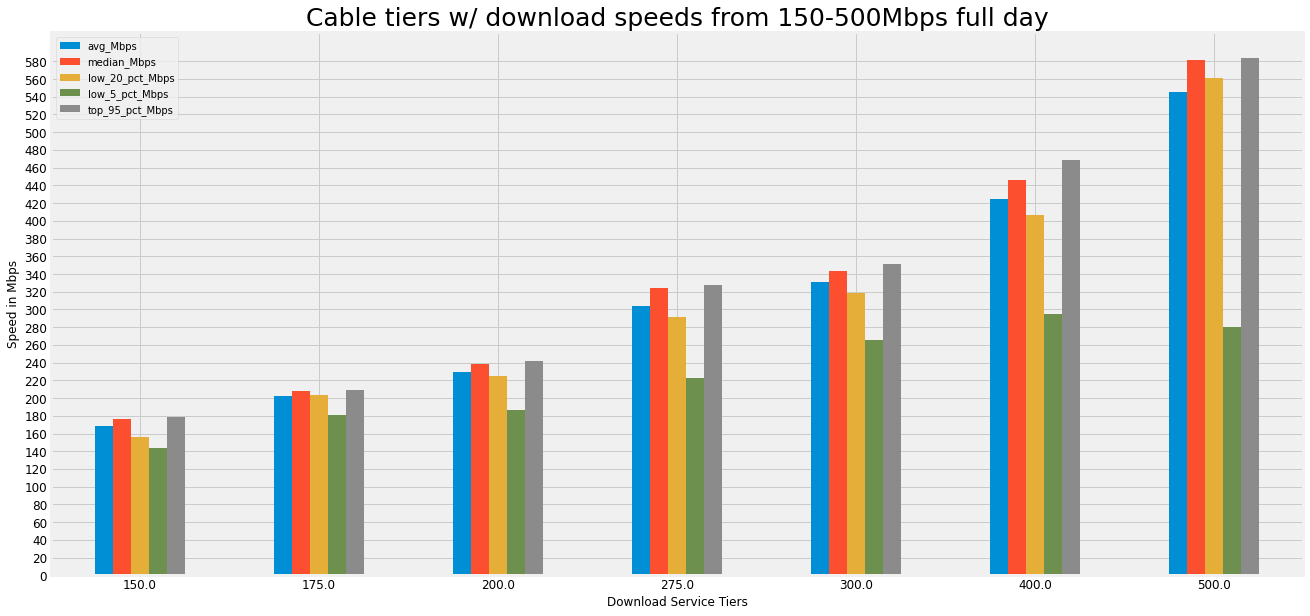

In [486]:
chartData = fullDay_download.where(fullDay_download.tech == 'Cable').groupby(['download_service_tier']).mean()

chartData = chartData[chartData.index > 100]
chartData= chartData[chartData.index <= 500]
ax = chartData.plot.bar(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, rot = 0, figsize = (20,10), grid = True)

# x = np.arange(0,270,5)
y = np.arange(0,600,20)


# ax.set_xticks()
ax.set_yticks(y)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Cable tiers w/ download speeds from 150-500Mbps full day', fontsize=25)

chartData

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
download_service_tier,,,,,,,,,,
50.0,56.104621,56.951508,50.946004,57.238452,56.282644,65.576364,15.581096,49.995268,2.461790,39.0
75.0,81.336204,82.075804,76.710116,83.009972,81.110308,88.845268,6.442404,82.402864,3.480771,46.5
100.0,98.806475,99.772372,93.683264,100.478892,98.614104,102.136580,24.997652,77.138928,3.006103,60.0
150.0,147.958061,149.364760,142.405168,150.281936,147.770264,153.086344,0.061504,153.024840,6.514487,25.0
200.0,250.139715,253.897176,228.192400,255.771504,250.503892,257.968856,23.327284,234.641572,12.273768,29.0
250.0,268.702963,272.236504,259.466384,272.563000,271.319128,369.846496,86.450560,283.395936,15.935389,42.0
500.0,456.969827,442.847428,342.688412,527.441412,416.067192,558.736712,10.262200,548.474512,79.913855,105.5


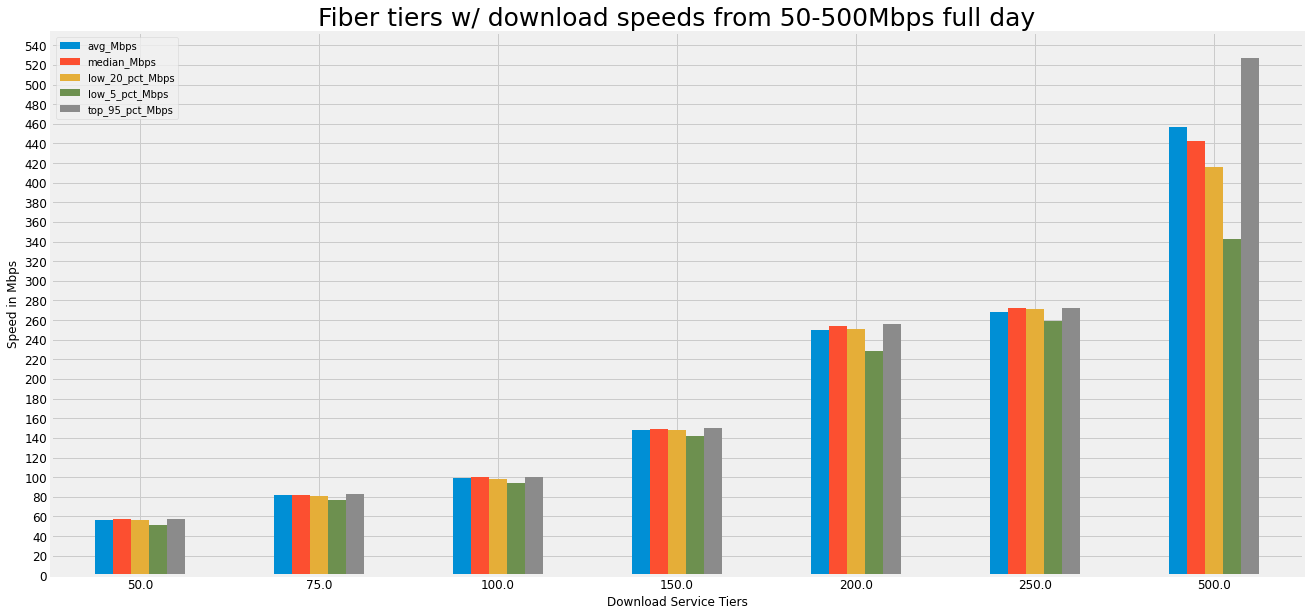

In [487]:
chartData = fullDay_download.where(fullDay_download.tech == 'Fiber').groupby(['download_service_tier']).mean()

chartData = chartData[chartData.index <= 500]
ax = chartData.plot.bar(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, rot = 0, figsize = (20,10), grid = True)

# x = np.arange(0,270,5)
y = np.arange(0,560,20)


# ax.set_xticks()
ax.set_yticks(y)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Fiber tiers w/ download speeds from 50-500Mbps full day', fontsize=25)

chartData

<h3> Barchart Tier analysis cable, fiber, dsl fullday upload

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
upload_service_tier,,,,,,,,,,
2.0,2.306709,2.331848,2.094456,2.451996,2.237432,2.642548,0.625672,2.016876,0.123543,21.500000
3.0,3.169538,3.196972,2.999656,3.278804,3.153036,3.689004,0.320844,3.368160,0.201383,52.000000
4.0,4.516048,4.540680,4.284600,4.672648,4.441024,4.985816,2.469416,2.516400,0.164288,14.000000
5.0,5.958213,5.797448,5.087520,7.542288,5.659003,319.575693,0.263629,319.312064,2.278568,87.000000
10.0,11.174141,11.046476,10.097862,12.846860,10.836476,13.895476,0.265682,13.629794,1.231558,85.750000
15.0,17.135553,17.394768,15.552048,17.868032,17.195808,18.192976,0.034672,18.158304,1.311346,37.000000
20.0,22.861196,23.240075,20.352331,24.851629,22.268808,25.935571,0.571864,25.363707,2.287004,57.000000
30.0,29.872871,30.538900,23.893796,33.068280,29.651964,35.434148,0.121348,35.312800,4.478685,42.000000
35.0,34.630785,36.582829,21.898213,39.518440,33.713661,40.711653,0.911488,39.800165,5.789238,74.333333


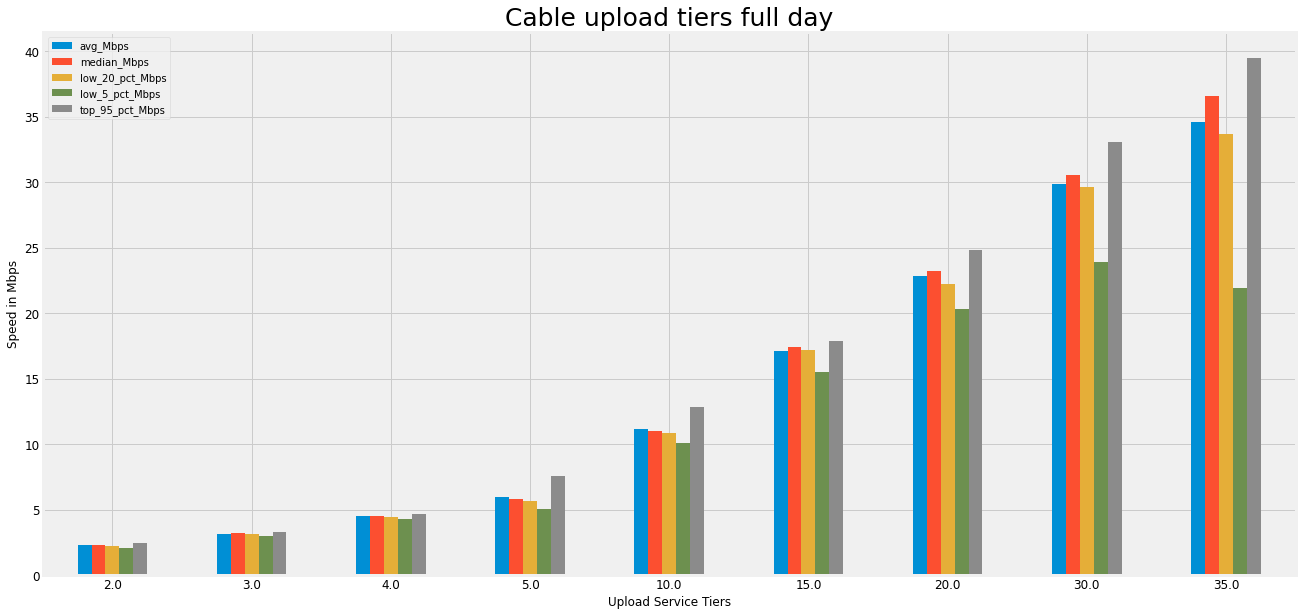

In [488]:
chartData = fullDay_upload.where(fullDay_upload.tech == 'Cable').groupby(['upload_service_tier']).mean()

# chartData = chartData[chartData.index <= 100]
ax = chartData.plot.bar(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, rot = 0, figsize = (20,10), grid = True)

# x = np.arange(0,270,5)
# y = np.arange(0,200,5)

# ax.set_xticks()
# ax.set_yticks()

ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Cable upload tiers full day', fontsize=25)

chartData

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
upload_service_tier,,,,,,,,,,
50.0,60.538715,61.864180,54.144576,66.648204,55.527820,70.592560,31.085584,39.506976,4.428535,38.5
75.0,82.588335,85.748832,70.452740,90.697040,74.032852,93.859288,11.660144,82.199144,7.607434,46.5
100.0,110.652711,113.048840,104.101525,115.767248,106.515675,124.879736,16.948451,107.931285,6.889878,54.0
125.0,131.809241,131.971648,130.214976,135.613776,131.746600,217.946792,1.543152,216.403640,7.073977,141.0
150.0,146.476894,150.987464,143.946032,163.664880,150.708296,164.726768,0.497000,164.229768,29.782761,25.0
200.0,261.585843,268.151416,220.158000,290.628124,259.829856,294.045596,48.755104,245.290492,26.519372,29.0
500.0,503.450266,505.804440,426.021056,555.887712,496.674408,563.450880,137.499112,425.951768,44.367938,70.0


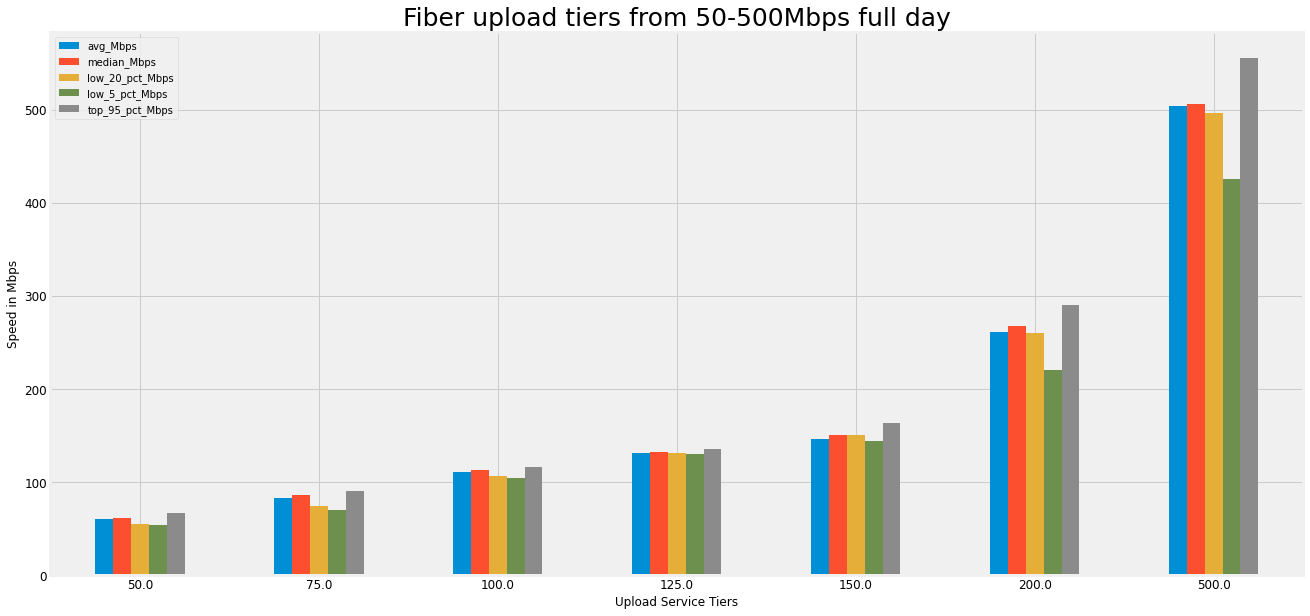

In [489]:
chartData = fullDay_upload.where(fullDay_upload.tech == 'Fiber').groupby(['upload_service_tier']).mean()

chartData = chartData[chartData.index <= 500]
ax = chartData.plot.bar(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, rot = 0, figsize = (20,10), grid = True)

# x = np.arange(0,270,5)
# y = np.arange(0,200,5)

# ax.set_xticks()
# ax.set_yticks()

ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Fiber upload tiers from 50-500Mbps full day', fontsize=25)

chartData

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,Mbps_range,STD,total_boxes
upload_service_tier,,,,,,,,,,
0.256,0.190928,0.203528,0.101776,0.248280,0.147624,0.493216,0.018472,0.474744,0.055637,20.0
0.384,0.532650,0.571720,0.200184,0.698992,0.354528,0.737888,0.070448,0.667440,0.167175,13.0
0.512,0.329353,0.297496,0.119656,0.664584,0.177192,0.778400,0.031280,0.747120,0.164379,51.0
0.640,0.635622,0.641952,0.473080,0.785912,0.561432,0.869752,0.123016,0.746736,0.095204,22.0
0.750,0.669256,0.687808,0.228152,0.904712,0.598344,1.014456,0.003352,1.011104,0.161193,35.0
0.768,0.590015,0.606595,0.363669,0.762738,0.480702,1.335269,0.085002,1.250267,0.132417,42.6
0.896,0.710113,0.706824,0.508488,0.883576,0.634128,101.051776,0.053680,100.998096,0.728985,134.0
1.000,0.899041,0.866082,0.641133,1.361448,0.730019,1.644744,0.179562,1.465182,0.229126,48.6
1.500,1.412395,1.442035,0.871765,2.064461,1.107123,2.336312,0.341091,1.995221,0.369189,63.0


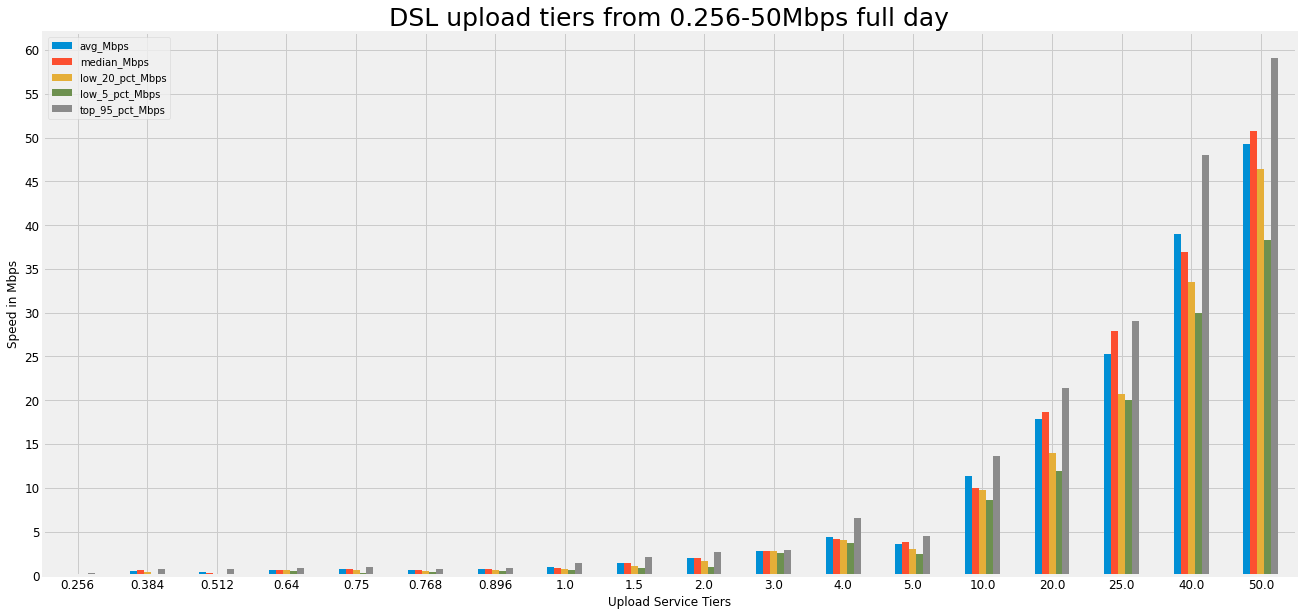

In [490]:
chartData = fullDay_upload.where(fullDay_upload.tech == 'DSL').groupby(['upload_service_tier']).mean()

# chartData = chartData[chartData.index <= 100]
ax = chartData.plot.bar(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, rot = 0, figsize = (20,10), grid = True)

# x = np.arange(0,270,5)
y = np.arange(0,65,5)

# ax.set_xticks()
ax.set_yticks(y)

ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('DSL upload tiers from 0.256-50Mbps full day', fontsize=25)

chartData